<a href="https://colab.research.google.com/github/MrFahadKabir/CVPR/blob/main/MID/Assignment1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Assignment: A comparison of manhattan (L1) and euclidean (L2) distances with 5-fold cross-validation

 **Name: GOLAM AHMED KABIR FAHAD**

 **ID: 22-48666-3**

 **Sec: C**

In [36]:
from google.colab import drive
drive.mount('/content/drive')

import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
import random


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [37]:
DATASET_DIR = "/content/drive/MyDrive/Colab Notebooks/animal_dataset"
IMG_SIZE = 32


In [38]:
def load_images_from_folder(base_folder, img_size=32, grayscale=True):
    X, y = [], []
    classes = sorted([d for d in os.listdir(base_folder) if os.path.isdir(os.path.join(base_folder, d))])
    print("Found classes:", classes)

    for class_name in classes:
        class_folder = os.path.join(base_folder, class_name)
        for filename in os.listdir(class_folder):
            file_path = os.path.join(class_folder, filename)
            img = cv2.imread(file_path, cv2.IMREAD_GRAYSCALE if grayscale else cv2.IMREAD_COLOR)
            if img is None:
                continue
            img_resized = cv2.resize(img, (img_size, img_size))
            X.append(img_resized.flatten())
            y.append(class_name)

    X = np.array(X, dtype=np.float32) / 255.0
    y = np.array(y)
    print(f"Loaded {X.shape[0]} images. Feature shape: {X.shape}")
    return X, y


In [39]:
X, y_str = load_images_from_folder(DATASET_DIR, img_size=IMG_SIZE)


classes = sorted(list(set(y_str)))
class_to_int = {cls: i for i, cls in enumerate(classes)}
int_to_class = {i: cls for cls, i in class_to_int.items()}

y = np.array([class_to_int[cls] for cls in y_str])

print("Label mapping:")
for cls, enc in class_to_int.items():
    print(f"{cls} -> {enc}")


Found classes: ['cat', 'dog', 'panda']
Loaded 300 images. Feature shape: (300, 1024)
Label mapping:
cat -> 0
dog -> 1
panda -> 2


In [40]:
def knn_predict(X_train, y_train, X_test, k=3, metric='euclidean'):
    y_pred = []
    for xt in X_test:
        if metric == 'euclidean':
            distances = np.sqrt(np.sum((X_train - xt) ** 2, axis=1))
        elif metric == 'manhattan':
            distances = np.sum(np.abs(X_train - xt), axis=1)
        else:
            raise ValueError("Invalid metric. Choose 'euclidean' or 'manhattan'.")

        nearest_indices = np.argsort(distances)[:k]
        nearest_labels = y_train[nearest_indices]
        counts = np.bincount(nearest_labels)
        y_pred.append(np.argmax(counts))

    return np.array(y_pred)


In [41]:
def stratified_kfold(X, y, n_splits=5, random_seed=42):
    np.random.seed(random_seed)
    folds = [[] for _ in range(n_splits)]
    for cls in np.unique(y):
        cls_indices = np.where(y == cls)[0]
        np.random.shuffle(cls_indices)
        cls_folds = np.array_split(cls_indices, n_splits)
        for i in range(n_splits):
            folds[i].extend(cls_folds[i])
    return folds


In [42]:
def cross_val_accuracy(X, y, k=3, metric='euclidean', n_splits=5):
    folds = stratified_kfold(X, y, n_splits)
    accuracies = []

    for i in range(n_splits):
        test_idx = np.array(folds[i])
        train_idx = np.array([idx for j in range(n_splits) if j != i for idx in folds[j]])
        X_train, y_train = X[train_idx], y[train_idx]
        X_test, y_test = X[test_idx], y[test_idx]
        y_pred = knn_predict(X_train, y_train, X_test, k=k, metric=metric)
        accuracies.append(np.mean(y_pred == y_test))

    return np.array(accuracies)


In [43]:
k_values = [1, 3, 5, 7, 9, 11]
metrics = ["euclidean", "manhattan"]
results = {metric: [] for metric in metrics}

for metric in metrics:
    print(f"\nDistance Metric: {metric}")
    for k in k_values:
        scores = cross_val_accuracy(X, y, k=k, metric=metric, n_splits=5)
        avg_acc = np.mean(scores)
        results[metric].append(avg_acc)
        print(f"K={k}: fold accuracies={scores}, avg={avg_acc:.4f}")



Distance Metric: euclidean
K=1: fold accuracies=[0.33333333 0.3        0.4        0.3        0.36666667], avg=0.3400
K=3: fold accuracies=[0.35       0.26666667 0.38333333 0.4        0.28333333], avg=0.3367
K=5: fold accuracies=[0.28333333 0.3        0.3        0.38333333 0.28333333], avg=0.3100
K=7: fold accuracies=[0.26666667 0.36666667 0.38333333 0.41666667 0.28333333], avg=0.3433
K=9: fold accuracies=[0.28333333 0.31666667 0.36666667 0.46666667 0.3       ], avg=0.3467
K=11: fold accuracies=[0.33333333 0.33333333 0.36666667 0.43333333 0.36666667], avg=0.3667

Distance Metric: manhattan
K=1: fold accuracies=[0.35       0.4        0.38333333 0.3        0.33333333], avg=0.3533
K=3: fold accuracies=[0.31666667 0.28333333 0.4        0.41666667 0.3       ], avg=0.3433
K=5: fold accuracies=[0.33333333 0.25       0.4        0.41666667 0.3       ], avg=0.3400
K=7: fold accuracies=[0.35       0.33333333 0.38333333 0.35       0.28333333], avg=0.3400
K=9: fold accuracies=[0.38333333 0.31666667

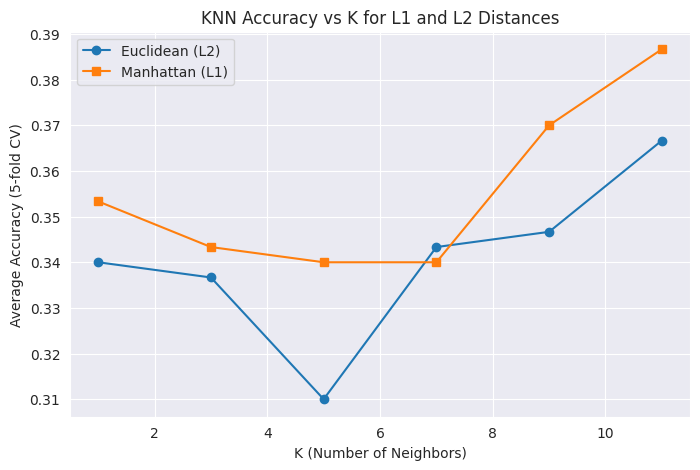

In [44]:
plt.figure(figsize=(8,5))
plt.plot(k_values, results["euclidean"], marker='o', label='Euclidean (L2)')
plt.plot(k_values, results["manhattan"], marker='s', label='Manhattan (L1)')
plt.xlabel("K (Number of Neighbors)")
plt.ylabel("Average Accuracy (5-fold CV)")
plt.title("KNN Accuracy vs K for L1 and L2 Distances")
plt.grid(True)
plt.legend()
plt.show()


In [45]:
best_k, best_metric, best_acc = None, None, -1
for metric in metrics:
    for k, acc in zip(k_values, results[metric]):
        if acc > best_acc:
            best_acc = acc
            best_k = k
            best_metric = metric

print(f"\nBest configuration:")
print(f"Distance Metric: {best_metric}")
print(f"K: {best_k}")
print(f"Average CV Accuracy: {best_acc:.4f}")



Best configuration:
Distance Metric: manhattan
K: 11
Average CV Accuracy: 0.3867


Final k-NN model trained on all training data.

Top 5 Predictions:
True: dog, Predicted: cat
True: dog, Predicted: cat
True: dog, Predicted: dog
True: panda, Predicted: cat
True: dog, Predicted: dog


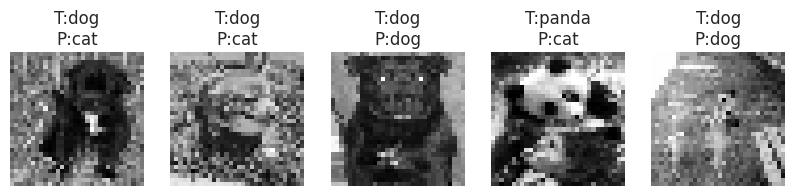

In [46]:
y_pred_final = knn_predict(X, y, X, k=best_k, metric=best_metric)
print("Final k-NN model trained on all training data.")


sample_indices = random.sample(range(X.shape[0]), 5)
X_sample = X[sample_indices]
y_sample_true = y[sample_indices]

y_pred_sample = knn_predict(X, y, X_sample, k=best_k, metric=best_metric)
y_pred_labels = [int_to_class[i] for i in y_pred_sample]
y_true_labels = [int_to_class[i] for i in y_sample_true]

print("\nTop 5 Predictions:")
for i in range(5):
    print(f"True: {y_true_labels[i]}, Predicted: {y_pred_labels[i]}")

plt.figure(figsize=(10,2))
for i, idx in enumerate(sample_indices):
    plt.subplot(1,5,i+1)
    plt.imshow(X[idx].reshape(IMG_SIZE, IMG_SIZE), cmap='gray')
    plt.title(f"T:{y_true_labels[i]}\nP:{y_pred_labels[i]}")
    plt.axis('off')
plt.show()


**Discussion**:

Here is the text reorganized into a structured, line-by-line format for better readability, with key points highlighted in bold.

Experimental Results & Analysis
Top Performance: Using 5-fold cross-validation, the Manhattan (L1) distance metric outperformed Euclidean (L2), achieving the highest accuracy with K = 11.

Why L1 Prevailed: Manhattan distance proved better suited for this specific task because it handles small variations in pixel values more robustly than Euclidean distance.

Dataset Characteristics: The dataset consists of 3 grayscale classes (32×32 images). While this low resolution reduces computation time, it results in the loss of fine details and creates overlapping features between classes.

Current Limitations:

Small image size limits detail.

k-NN is highly sensitive to the choice of K.

Computation costs increase significantly with larger datasets.

Potential Improvements:

Implement feature extraction techniques (e.g., HOG, PCA).

Utilize higher resolution images or data augmentation.

Switch to advanced classifiers like SVMs or Convolutional Neural Networks (CNN).